# Importing libraries

In [7]:
import os
import random
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Define Parameters

In [15]:
# Define parameters,dataset=celebA
img_dir = 'C:/Users/dijis/Downloads/archive (8)/img_align_celeba/img_align_celeba'  
batch_size = 8
upscale_size = (64, 64)  # Low-resolution images size
target_size = (128, 128)  # High-resolution target images size
subset_size = 10000  # Reduced to 10,000 images

# Define data generator

In [16]:
# Define data generator
def data_generator(img_dir, batch_size, upscale_size, target_size, subset_size):
    filenames = os.listdir(img_dir)
    subset_filenames = random.sample(filenames, subset_size)
    while True:
        for i in range(0, len(subset_filenames), batch_size):
            batch_filenames = subset_filenames[i:i+batch_size]
            lr_images = []
            hr_images = []

            for filename in batch_filenames:
                # Load and process images
                hr_img = load_img(os.path.join(img_dir, filename), target_size=target_size)
                lr_img = load_img(os.path.join(img_dir, filename), target_size=upscale_size)
                hr_images.append(img_to_array(hr_img) / 255.0)
                lr_images.append(img_to_array(lr_img) / 255.0)

            yield np.array(lr_images), np.array(hr_images)


# Define model with reduced upsampling to target 128x128

In [17]:
# Define model with reduced upsampling to target 128x128
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(upscale_size[0], upscale_size[1], 3)),
    UpSampling2D(size=(2, 2)),  # Upscale to 128x128
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

# Compile model

In [18]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model

In [19]:
# Train model
steps_per_epoch = subset_size // batch_size
history = model.fit(
    data_generator(img_dir, batch_size, upscale_size, target_size, subset_size),
    steps_per_epoch=steps_per_epoch,
    epochs=5  # Reduced to 5 epochs for faster testing
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3429s 3s/step - loss: 0.0098
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3996s 3s/step - loss: 0.0024
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3078s 2s/step - loss: 0.0023
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2774s 2s/step - loss: 0.0022
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2255s 2s/step - loss: 0.0022


# Evaluation

In [24]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the upscale_image function
def upscale_image(model, lr_img_array):
    """Preprocesses a low-res image array, predicts, and returns the upscaled image array."""
    lr_img_array = np.expand_dims(lr_img_array, axis=0)  # Add batch dimension
    sr_img_array = model.predict(lr_img_array)[0]        # Remove batch dimension after prediction
    return sr_img_array

def evaluate_accuracy(model, test_img_dir, num_samples=10, target_size=(128, 128), upscale_size=(64, 64)):
    """Calculate accuracy-like metrics (MSE, MAE) for the model."""
    mse_values = []
    mae_values = []
    
    test_filenames = os.listdir(test_img_dir)[:num_samples]
    
    for filename in test_filenames:
        # Load high-res image
        hr_img_path = os.path.join(test_img_dir, filename)
        hr_img = Image.open(hr_img_path).convert("RGB")
        hr_img = hr_img.resize(target_size)  # Resize to target high-res size
        hr_img_array = img_to_array(hr_img) / 255.0
        
        # Create low-res image
        lr_img = hr_img.resize(upscale_size)
        lr_img_array = img_to_array(lr_img) / 255.0
        
        # Predict super-resolution image
        sr_img_array = upscale_image(model, lr_img_array)
        
        # Flatten the arrays for MSE/MAE calculation
        hr_flat = hr_img_array.flatten()
        sr_flat = sr_img_array.flatten()
        
        # Calculate MSE and MAE
        mse = mean_squared_error(hr_flat, sr_flat)
        mae = mean_absolute_error(hr_flat, sr_flat)
        
        mse_values.append(mse)
        mae_values.append(mae)
    
    # Calculate average MSE and MAE over the test set
    avg_mse = np.mean(mse_values)
    avg_mae = np.mean(mae_values)
    
    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average MAE: {avg_mae:.4f}")


evaluate_accuracy(
    model, 
    test_img_dir='C:/Users/dijis/Downloads/archive (8)/img_align_celeba/img_align_celeba', 
    num_samples=10,
    target_size=(128, 128),
    upscale_size=(64, 64)
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Average MSE: 0.0012
Average MAE: 0.0216


# Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


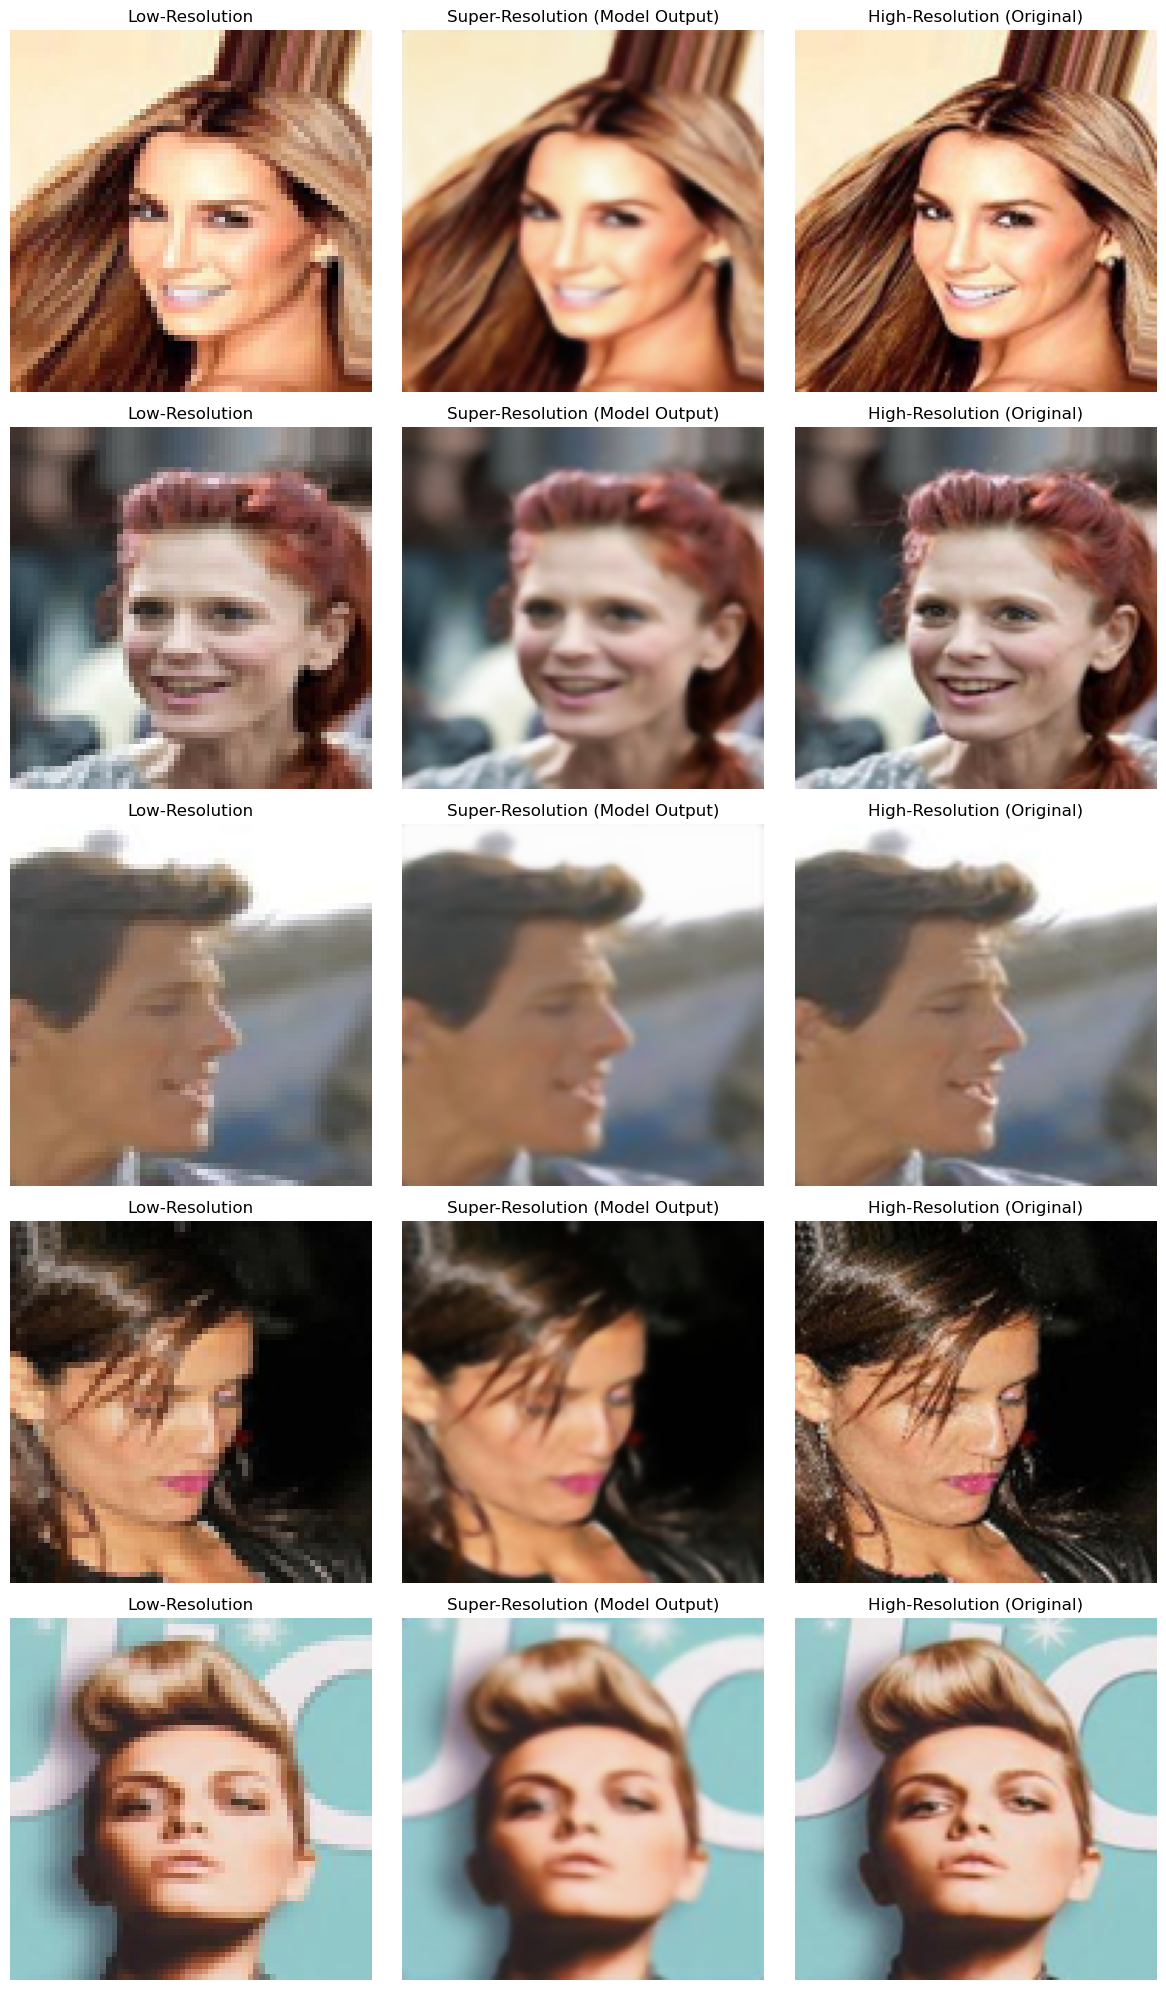

In [25]:
import matplotlib.pyplot as plt

def upscale_image(model, lr_image):
    """Upscales a single low-resolution image using the trained model."""
    lr_image = np.expand_dims(lr_image, axis=0)  
    sr_image = model.predict(lr_image)
    return sr_image[0]  

# Define paths for test images
test_img_dir =  'C:/Users/dijis/Downloads/archive (8)/img_align_celeba/img_align_celeba'  
num_test_samples = 5  # Number of test samples to visualize

# Load a few test images to visualize the model's performance
test_filenames = os.listdir(test_img_dir)[:num_test_samples]

plt.figure(figsize=(12, num_test_samples * 4))

for i, filename in enumerate(test_filenames):
    # Load a test image
    img_path = os.path.join(test_img_dir, filename)
    hr_img = Image.open(img_path)
    hr_img = hr_img.resize(target_size)  # Original high-res image resized for comparison
    lr_img = hr_img.resize(upscale_size)  # Create low-res version

    # Preprocess low-res image for the model
    lr_img_array = img_to_array(lr_img) / 255.0

    # Upscale low-res image using the model
    sr_img = upscale_image(model, lr_img_array)

    # Display the low-res, super-res (upscaled), and high-res images
    plt.subplot(num_test_samples, 3, 3 * i + 1)
    plt.imshow(lr_img)
    plt.title("Low-Resolution")
    plt.axis('off')

    plt.subplot(num_test_samples, 3, 3 * i + 2)
    plt.imshow(sr_img)
    plt.title("Super-Resolution (Model Output)")
    plt.axis('off')

    plt.subplot(num_test_samples, 3, 3 * i + 3)
    plt.imshow(hr_img)
    plt.title("High-Resolution (Original)")
    plt.axis('off')

plt.tight_layout()
plt.show()
